# Noah Samples Capstone Redo!
This is a the final model for my Capstone project from 2021.
Issues with previous models and my map can be found in the 'Changes' notebook in this file.

In [2]:
import pylab as py
import pandas as pd
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fsolve

In [6]:
Vc = 9.834
Vh = 9.416
n=127
Ae = .0001
Le = 0.0025
ns = 14
zs = 0.00153
ts = 0.00055
bsc = .025
bsh = .027
rhoh = 1.05
cph= 1008
vh = .000018
kh = 0.028
prh = 0.703
rhoc = 1.161
cpc = 1007
vc = .00001589
kc = 0.0263
prc = 0.707 
ls = .027
kAl = 142
tAl = 0.0191
aAl = 0.03 * .02
re = 0.02
rL = re
alpha = 0.00041427

In [7]:
rezh = (Vh*zs*zs)/(vh*ls)
Ach = ns * bsh * zs
mdoth = rhoh * Vh * Ach
hh = (kh/zs)*((rezh * prh/2)**-3 + (0.664*np.sqrt(rezh)*(prh**(1/3))*np.sqrt(1+(3.65/np.sqrt(rezh))))**-3)**-(1/3)
mh = np.sqrt((hh*2*(ls+ts))/(kAl*ls*ts))
nfh = np.tanh(mh*bsh)/(mh*bsh)
Ash = ns * (2*(ts+ls)*bsh + (zs*ls))
Afh = 2 * bsh*(ls+ts)
noh = 1 - (n*(Afh/Ash)*(1-nfh))
nsh = ((1/noh)+((hh*Ash*tAl)/(kAl*aAl)))**-1

rezc = (Vc*zs*zs)/(vc*ls)
Acc = ns * bsc * zs
mdotc = rhoc * Vc * Acc
hc = (kc/zs)*((rezc * prc/2)**-3 + (0.664*np.sqrt(rezc)*(prc**(1/3))*np.sqrt(1+(3.65/np.sqrt(rezc))))**-3)**-(1/3)
mc = np.sqrt((hc*2*(ls+ts))/(kAl*ls*ts))
nfc = np.tanh(mc*bsc)/(mc*bsc)
Asc = ns * (2*(ts+ls)*bsc + (zs*ls))
Afc = 2 * bsc*(ls+ts)
noc = 1 - (n*(Afc/Asc)*(1-nfc))
nsc = ((1/noc)+((hc*Asc*tAl)/(kAl*aAl)))**-1
Ke = (kAl*Ae)/Le

In [8]:
def solver(z):
    II = z[0]
    Qc = z[1]
    Qh = z[2]
    Tc = z[3]
    Th = z[4]
    Tinfcout = z[5]
    Tinfhout = z[6]
    Tinfhin = z[7]
    Tinfcin = z[8]
    
    F = np.empty((9))
    F[0] = mdoth * cph * (Tinfhin - Tinfhout) - Qh
    F[1] = nsh * hh * Ash * ((Tinfhin + Tinfhout)/2 - Th) - Qh
    F[2] = n * (alpha * II * Th - 1/2 * (II**2) * re + (Ke * (Th-Tc))) - Qh
    F[3] = n * (alpha * II * Tc + 1/2 * (II**2) * re + (Ke * (Th-Tc))) - Qc
    F[4] = nsc * hc * Asc * (Tc - (Tinfcin + Tinfcout)/2) - Qc
    F[5] = mdotc * cpc * (Tinfcin - Tinfcout) - Qc
    F[6] = (alpha * (Th - Tc))/(rL/n + re) - II
    F[7] = z[7] -Tinfhin
    F[8] = z[8] - Tinfcin
    
    return F

# In order to get correct current estimations, need to pass in hot and cold temps. Added 2 'equations' to the solver.

In [9]:
df = pd.read_csv("temps.csv")

In [12]:
hot = np.round(np.arange(df['TC (C)'].min() + 273.13, df['TC (C)'].max() + 273.13,0.5),2)
cold = np.round(np.arange(df['Amb (C)'].min() + 273.13, df['Amb (C)'].max() + 273.13,(df['Amb (C)'].max() - df['Amb (C)'].min())/hot.shape[0]),2)

In [13]:
zval = []
for u in range(hot.shape[0]):
    for v in range(cold.shape[0]):
        guess = np.array([1,1,1,1,1,1,1,hot[u],cold[v]])
        z = fsolve(solver, guess)
        zval.append(z[0])
        
zvalarr = np.array(zval)

[[-0.00532397 -0.00531728 -0.00530837 ... -0.00475324 -0.00474655
  -0.00473763]
 [-0.00543544 -0.00542875 -0.00541983 ... -0.0048647  -0.00485802
  -0.0048491 ]
 [-0.00554691 -0.00554022 -0.0055313  ... -0.00497617 -0.00496948
  -0.00496057]
 ...
 [-0.01357195 -0.01356527 -0.01355635 ... -0.01300127 -0.01299459
  -0.01298567]
 [-0.01368341 -0.01367672 -0.0136678  ... -0.01311273 -0.01310604
  -0.01309712]
 [-0.01379486 -0.01378817 -0.01377925 ... -0.01322418 -0.01321749
  -0.01320857]]


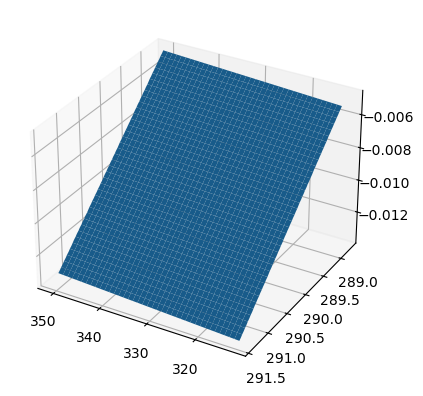

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
HOT, COLD = np.meshgrid(hot,cold)
curr = zvalarr.reshape(HOT.shape)
print(curr)
ax.plot_surface(HOT, COLD, curr)
ax.invert_xaxis()
ax.invert_yaxis()
ax.view_init(elev=30, azim=-60, roll=0)
plt.show()